# Finding Outliers

In [50]:
import os

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [2]:
# Read training and test data

earnings_df = pd.read_csv("fraud_data_new.csv")

In [3]:
earnings_df.sample(10)

,company_id,dsri,gmi,aqi,sgi,depi,sgai,accr,levi,status
409,410,1.134393,1.209066,1.660997,1.235956,1.084340,1.074128,-0.032658,1.207059,No
642,643,1.361375,1.103601,1.272158,0.900477,0.973495,0.772537,0.001252,1.110383,No
1044,1045,1.063227,1.259564,-0.275252,0.842003,0.807891,1.000000,-0.089392,0.960065,No
1043,1044,1.238849,1.057584,1.026933,1.000288,0.929404,0.631542,-0.075913,1.132258,No
1144,1145,0.926926,0.910272,0.852578,1.065012,0.593965,1.801949,-0.103330,1.013344,No
546,547,1.321181,0.710709,0.832165,1.220635,0.970630,0.974891,0.095085,0.735368,No
355,356,0.980680,0.994670,0.893846,1.100498,0.915084,1.301410,-0.015111,0.762835,No
982,983,1.803483,0.869359,-1.556569,1.072134,0.996277,0.733334,0.080736,1.136785,No
529,530,0.985958,1.157131,11.111603,1.149656,0.951745,1.292239,0.015212,1.190836,No
670,671,1.404746,0.934590,3.987590,0.926783,1.103845,0.696446,-0.112703,1.072661,No


In [4]:
np.sum(earnings_df.isna())

company_id    0
dsri          0
gmi           0
aqi           0
sgi           0
depi          0
sgai          0
accr          0
levi          0
status        0
dtype: int64

In [5]:
earnings_df['status'] = earnings_df['status'].map(lambda x: 1 if x == 'Yes' else 0)

In [6]:
earnings_df.sample(10)

,company_id,dsri,gmi,aqi,sgi,depi,sgai,accr,levi,status
780,781,1.106772,1.042221,0.986585,0.976621,0.860691,1.017990,-0.024714,1.027712,0
1221,1222,1.317955,1.212199,0.831690,1.103667,0.529804,0.981033,0.094074,1.233937,0
864,865,0.987056,0.990120,0.789278,1.076565,0.901102,0.801138,-0.061825,0.750410,0
557,558,0.695871,0.978548,1.088167,1.948790,0.900055,0.000000,0.146425,0.837702,0
513,514,1.175316,0.656361,-2.998387,1.177730,1.066338,0.882568,0.039792,0.987185,0
839,840,1.270889,3.190908,1.428714,0.589657,1.076399,1.053438,-0.452952,1.275033,0
135,136,0.974728,0.973973,1.406654,0.946908,0.949789,0.000000,-0.018634,0.972530,0
204,205,0.866454,0.868075,1.389797,0.827259,1.044388,1.108178,-0.129363,1.151066,0
332,333,1.314737,0.969082,1.143160,1.015301,0.945115,1.008946,-0.063980,0.952622,0
419,420,0.957256,0.924780,1.342400,1.174551,1.029274,1.264377,-0.039415,0.973888,0


In [7]:
earnings_df.status.value_counts()

status
0    1200
1      39
Name: count, dtype: int64

In [33]:
x_features = list(earnings_df.columns)
x_features.remove('company_id')
x_features.remove('status')

In [34]:
x_features

['dsri', 'gmi', 'aqi', 'sgi', 'depi', 'sgai', 'accr', 'levi']

In [35]:
earnings_df[x_features].shape

(1239, 8)

In [36]:
earnings_df['status'].shape

(1239,)

# Algorithms

In [16]:
# Create a results dataframe to store and later compare results

def fit_model(input_data, model_fn, model_args=None, threshold=0.15, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

## Isolation Forest

In [163]:
def fit_isolation_forest(input_data, args=None, threshold=0.5, labels=None):
    model = IsolationForest(n_estimators = 200, 
                            contamination=threshold, 
                            random_state=100)
    
    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

In [164]:
if_model = fit_model(earnings_df[x_features], fit_isolation_forest) 

In [165]:
scores = if_model.decision_function(earnings_df[x_features])

In [166]:
scores

array([-0.05268533, -0.25093424,  0.04205907, ...,  0.03213279,
        0.07097401,  0.05717345])

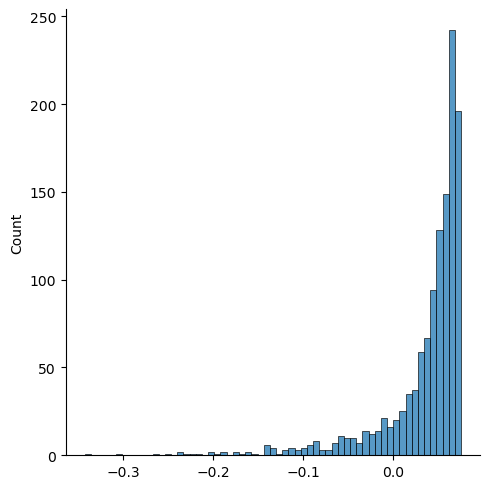

In [167]:
sn.displot(scores);

In [168]:
y_pred_test = predict_model(earnings_df[x_features], 
                            if_model, 
                            predict_isolation_forest)

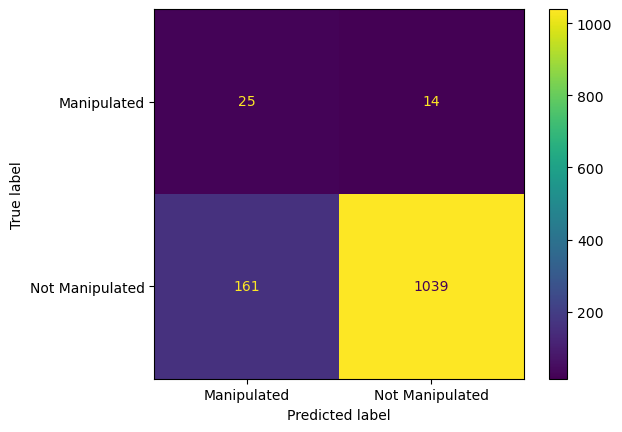

In [169]:
cm = confusion_matrix(earnings_df['status'],
                      y_pred_test, 
                      labels = [1, 0])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['Manipulated', 'Not Manipulated'])
cm_plot.plot();

In [170]:
print("Classification Report:\n", 
      classification_report(earnings_df['status'],
                            y_pred_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92      1200
           1       0.13      0.64      0.22        39

    accuracy                           0.86      1239
   macro avg       0.56      0.75      0.57      1239
weighted avg       0.96      0.86      0.90      1239



## Adjusting Contamination Values

In [171]:
threshold_vals = list(np.arange(0.05, 
                                0.20, 
                                0.01))

In [172]:
from sklearn.metrics import recall_score

In [173]:
threshold_recall = []

for threshold in threshold_vals:
    if_model = fit_model(earnings_df[x_features], 
                         fit_isolation_forest, 
                         threshold = threshold)
    
    y_pred_test = predict_model(earnings_df[x_features], 
                                if_model, 
                                predict_isolation_forest)    
    threshold_recall.append([np.round(threshold, 3), 
                             np.round(recall_score(earnings_df['status'], 
                                                   y_pred_test), 2)])

In [174]:
threshold_recall_df = pd.DataFrame(threshold_recall, 
                                   columns = ['threshold', 'recall'])

In [175]:
threshold_recall_df.sort_values("recall", ascending = False)

,threshold,recall
14,0.19,0.72
15,0.20,0.72
12,0.17,0.69
13,0.18,0.69
9,0.14,0.64
10,0.15,0.64
11,0.16,0.64
5,0.10,0.62
6,0.11,0.62
7,0.12,0.62


In [176]:
if_model = fit_model(earnings_df[x_features],
                     fit_isolation_forest, 
                     threshold = 0.20) 

y_pred_test = predict_model(earnings_df[x_features], 
                            if_model, 
                            predict_isolation_forest)

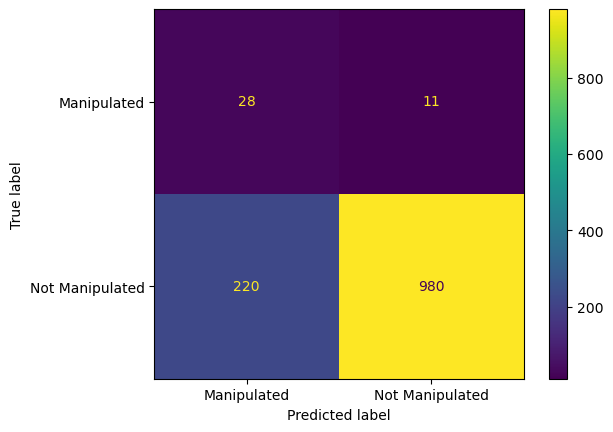

In [177]:
cm = confusion_matrix(earnings_df['status'],
                      y_pred_test, labels = [1, 0])
cm_plot = ConfusionMatrixDisplay(cm, 
                                 display_labels=['Manipulated', 'Not Manipulated'])
cm_plot.plot();

## Using pyod library

In [178]:
#!pip install pyod

In [179]:
from pyod.models.iforest import IForest

In [187]:
iforest = IForest(n_estimators = 200,
                  max_features = 1.0,
                  contamination = 0.2)

In [188]:
iforest.fit(earnings_df[x_features])

IForest(behaviour='old', bootstrap=False, contamination=0.2, max_features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=None,
    verbose=0)

In [189]:
iforest.labels_

array([1, 1, 0, ..., 0, 0, 0])

In [190]:
iforest_scores = iforest.decision_function(earnings_df[x_features])

In [191]:
iforest_scores

array([ 0.07616491,  0.23837383, -0.03104715, ..., -0.01628856,
       -0.05313968, -0.04346964])

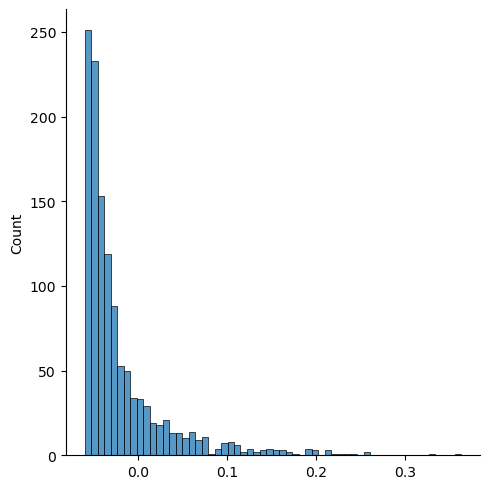

In [192]:
sn.displot(iforest_scores);

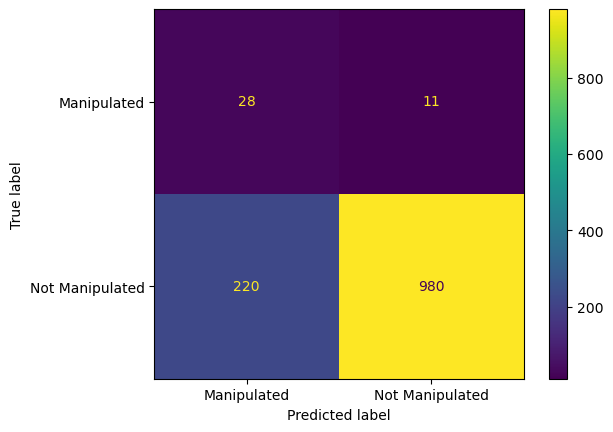

In [193]:
cm = confusion_matrix(earnings_df['status'],
                      iforest.labels_, 
                      labels = [1, 0])
cm_plot = ConfusionMatrixDisplay(cm, 
                                 display_labels=['Manipulated', 'Not Manipulated'])
cm_plot.plot();